In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm
import math

%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


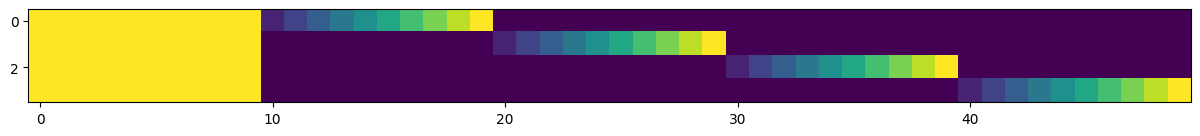

In [13]:
seq_class = []
total_tokens = 50
offset = 10 

for i in range(4):
    temp = np.zeros(total_tokens)
    temp[:offset] = 1
    temp[(i+1)*offset:((i+2)*offset)] = np.arange(0.1,1.1,0.1)
    temp = temp/sum(temp)
    seq_class.append(temp)
    assert(sum(seq_class[i])==1)
plt.figure(figsize=(15,10))
plt.imshow(np.vstack(seq_class))
    
def sample_sequence(next_token,seq_len,batch_size):
    '''
    function to sample a sequence based on p(l|m,n) for given m and n.
    '''
    query_tokens = [5,6,7,8]
    next_tokens = [1,2,3,4]
    
    if next_token==next_tokens[0]:
        context_tokens = np.random.choice(np.arange(50),p=seq_class[0],size=(batch_size,seq_len-2))
        #seq = np.append(context_tokens,[[query_tokens[0],next_token]],axis=1)
    if next_token==next_tokens[1]:
        context_tokens = np.random.choice(np.arange(50),p=seq_class[1],size=(batch_size,seq_len-2))
        #seq = np.append(context_tokens,[[query_tokens[1],next_token]])
    if next_token==next_tokens[2]:
        context_tokens = np.random.choice(np.arange(50),p=seq_class[2],size=(batch_size,seq_len-2))
        #seq = np.append(context_tokens,[[query_tokens[2],next_token]])
    if next_token==next_tokens[3]:
        context_tokens = np.random.choice(np.arange(50),p=seq_class[3],size=(batch_size,seq_len-2))
        #seq = np.append(context_tokens,[[query_tokens[3],next_token]])
    return context_tokens
def generate_data(batch_size,seq_len):
    next_tokens = [1,2,3,4]
    query_tokens = [5,6,7,8]
    #for i in range(batch_size):
    #next_token = np.random.choice(next_tokens,p=[0.25]*4)
    generated_seq_1 = torch.tensor(sample_sequence(next_tokens[0],seq_len,batch_size))
    
    generated_seq_2 = torch.tensor(sample_sequence(next_tokens[1],seq_len,batch_size))
    generated_seq_3 = torch.tensor(sample_sequence(next_tokens[2],seq_len,batch_size))
    generated_seq_4 = torch.tensor(sample_sequence(next_tokens[3],seq_len,batch_size))
     
    generated_seq_1 =torch.cat((generated_seq_1,
                                torch.tensor([[next_tokens[0],query_tokens[0]]]*batch_size)),dim=1)
    
    generated_seq_2 =torch.cat((generated_seq_2,
                                torch.tensor([[next_tokens[1],query_tokens[1]]]*batch_size)),dim=1)
        
    generated_seq_3 =torch.cat((generated_seq_3,
                                torch.tensor([[next_tokens[2],query_tokens[2]]]*batch_size)),dim=1)
    generated_seq_4 =torch.cat((generated_seq_4,
                                torch.tensor([[next_tokens[3],query_tokens[3]]]*batch_size)),dim=1)
    batch_of_seqs = torch.cat((generated_seq_1,generated_seq_2,generated_seq_3,generated_seq_4))
    
    
    indexes = torch.randperm(batch_size*4)
    return batch_of_seqs[indexes]



def analyse_model(model,batch_size,seq_len):
    test_inputs = generate_data(batch_size,seq_len)
    
    tinputs,tlabels  = test_inputs[:,:-1].to(device),test_inputs[:,-1].to(device)
    
    tinputs = F.one_hot(tinputs,num_classes=55).float()
    print(tinputs)
    
    model.eval()
    with torch.no_grad():
        model_output,model_attention = model(tinputs)
    #model_output = nn.Softmax(dim=1)(model_output)

    common_tokens_attn = []
    distinct_tokens_attn = []
    for i in range(batch_size):
        indices_1 = torch.logical_and(tinputs[i]>=0,tinputs[i]<10)
        indices_2 = torch.logical_and(tinputs[i]>=10,tinputs[i]<50)
        common_tokens_attn.append(sum(model_attention[i][indices_1]).item())
        distinct_tokens_attn.append(sum(model_attention[i][indices_2]).item())
    return np.mean(common_tokens_attn),np.mean(distinct_tokens_attn)


# class Net_p1(nn.Module):
#     def __init__(self):
#         super(Net_p1,self).__init__()
#         self.key_query_layer = nn.Linear(55,55,bias=False)
#         self.prediction_layer = nn.Linear(55,55)
        
#         self.key_query_layer.weight = nn.Parameter(torch.zeros(55,55))
#     def forward(self,x):
#         batch,seq_len,vocab_size = x.shape
#         key_query = torch.unsqueeze(self.key_query_layer(x[:,-1]),dim=1)
#         scores = (key_query@x.transpose(-2,-1))*(1/math.sqrt(key_query.size(-1)))
#         attn = nn.Softmax(dim=-1)(scores)
        
        
#         context = torch.matmul(attn,x)
    
#         output = self.prediction_layer(context)
#         return output[:,0,:],attn[:,0,:]
    
    

class Net_p1_fixed_attn(nn.Module):
    def __init__(self):
        super(Net_p1_fixed_attn,self).__init__()
        self.alpha = alpha
        #self.value_layer = nn.Linear(50,50)
        self.prediction_layer = nn.Linear(50,50)
        print(self.alpha)
    def forward(self,x,alpha):
        batch,seq_len = x.shape
        attn = torch.ones(batch,seq_len,device=device)
        index = x>9

        s1 = torch.sum(index,dim=1,keepdims=True)
        s2 = torch.sum(~index,dim=1,keepdims=True)

        mask = index.long()

        attn = ( alpha*(attn*mask*(1/s1)) )  + ( (1- alpha)*(attn*(1-mask)*(1/s2) )   ) 

        x = F.one_hot(x,num_classes=50).float()
        x = x #self.value_layer(x)
        context = torch.matmul(attn[:,None,:],x)
        output = self.prediction_layer(context)
        return output[:,0,:],attn


In [14]:
def calculate_loss(model,alpha,criterion):
    model.eval()
    n_batches = 1000
    with torch.no_grad():
        running_loss = 0.0
        for j in range(n_batches):
            data = generate_data(batch_size,seq_len)
            inputs,labels = data[:,:-1].to(device),data[:,-1].to(device)
            outputs,_ = model(inputs,alpha)
            loss = criterion(outputs,labels)
            running_loss +=loss.item()
    model.train()
    return running_loss/n_batches
         
        
        

In [15]:
n_epochs = 500
n_batches = 250
batch_size= 32 
seq_len = 64

alpha_values = [0.2,0.4,0.6,0.8,1]
loss_alpha = []
loss_alpha_ = []
for alpha in alpha_values:
    
    torch.manual_seed(1234)
    model = Net_p1_fixed_attn().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=1e-2)
    #running_loss = 0
    loss_epoch_wise = []
    loss_epoch_wise_ = []
    
    loss_epoch_wise.append(calculate_loss(model,alpha,criterion))
    loss_epoch_wise_.append(calculate_loss(model,alpha+0.005,criterion))
    
    for epoch in tqdm(range(n_epochs)):
        model.train()
        for j in range(n_batches):
            data = generate_data(batch_size,seq_len)
            inputs,labels = data[:,:-1].to(device),data[:,-1].to(device)
            optimizer.zero_grad()
            outputs,a = model(inputs,alpha)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            #running_loss +=loss.item()
        loss_epoch_wise.append(calculate_loss(model,alpha,criterion))
        loss_epoch_wise_.append(calculate_loss(model,alpha+0.005,criterion))
        
        #running_loss = 0.0 
    print(loss_epoch_wise[-1])
    loss_alpha.append(loss_epoch_wise)
    loss_alpha_.append(loss_epoch_wise_)
    loss_epoch_wise = [] 
    loss_epoch_wise_ = [] 

print("Finished Training") 

0.2


100%|█████████████████████████████████████████| 500/500 [23:10<00:00,  2.78s/it]


0.5978110085725784
0.4


100%|█████████████████████████████████████████| 500/500 [22:52<00:00,  2.74s/it]


0.15828193660080433
0.6


100%|█████████████████████████████████████████| 500/500 [23:37<00:00,  2.83s/it]


0.06446371345594526
0.8


100%|█████████████████████████████████████████| 500/500 [23:51<00:00,  2.86s/it]


0.0345977044776082
1


100%|█████████████████████████████████████████| 500/500 [23:04<00:00,  2.77s/it]

0.021514979483559727
Finished Training


In [16]:
correct = 0 
total = 0
model.eval()
with torch.no_grad():
    running_loss = 0.0
    for j in range(250):
        data = generate_data(batch_size,seq_len)
        inputs,labels = data[:,:-1].to(device),data[:,-1].to(device)
        #inputs = F.one_hot(inputs,num_classes=55).float()
        outputs,_ = model(inputs,alpha=1)
        loss = criterion(outputs,labels)
        running_loss +=loss.item()
        correct += sum(outputs.max(1)[1]==labels).item()
        total += len(labels)
print(f'loss:{running_loss/(j+1):.3f}')
print(f'accuracy:{correct/total:.3f}')

loss:0.022
accuracy:1.000


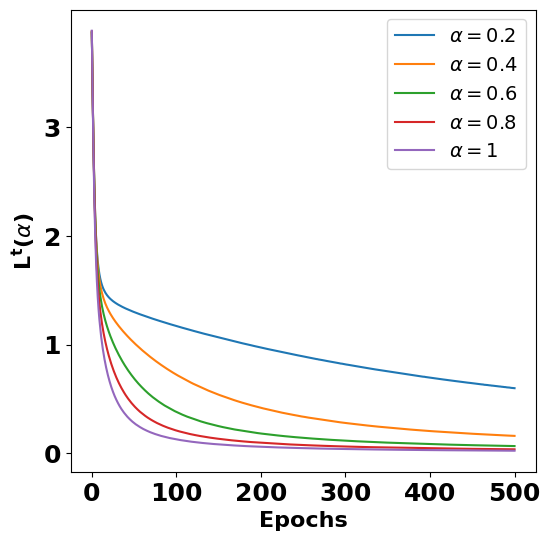

In [18]:
plt.figure(figsize=(6, 6))
for i in range(len(loss_alpha)):
    plt.plot(loss_alpha[i],label=r"$\alpha={"+str(alpha_values[i])+"}$")
    plt.xlabel("Epochs",weight="bold",fontsize=16)
    plt.ylabel(r"$\bf L^{t}$($ \alpha$)",weight="bold",fontsize=16)
    plt.xticks([0,100,200,300,400,500],weight="bold",fontsize=18)
    plt.yticks([3,2,1,0],weight="bold",fontsize=18)
plt.legend(bbox_to_anchor=[1., 1],prop={'size': 14})
plt.savefig("W_OV.pdf",bbox_inches='tight')


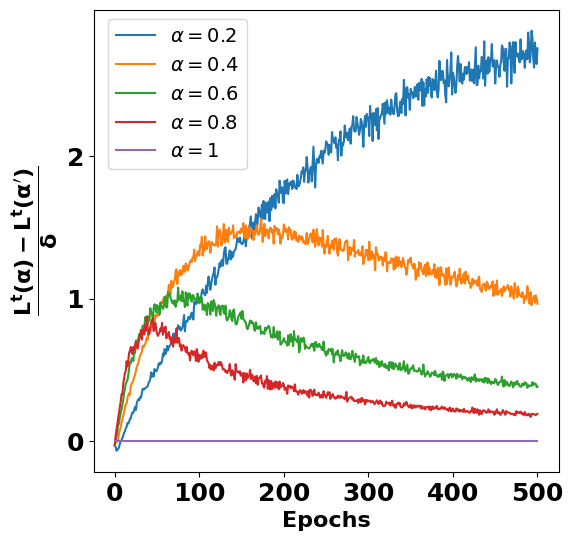

In [21]:
plt.figure(figsize=(6,6))
for i in range(len(loss_alpha)):
    if alpha_values[i] ==1:
        temp  = (np.array(loss_alpha[i])-np.array(loss_alpha[i]))/0.005
    else:
        temp  = (np.array(loss_alpha[i])-np.array(loss_alpha_[i]))/0.005
    plt.plot(temp,label=r"$\alpha={"+str(alpha_values[i])+"}$")
    plt.xlabel("Epochs",weight="bold",fontsize=16)
    plt.ylabel(r"$\bf \dfrac{L^{t}( \alpha) - \bf L^{t}( \alpha')}{ \delta}$",weight="bold",fontsize=16)
    
    plt.xticks([0,100,200,300,400,500],weight="bold",fontsize=18)
    plt.yticks([0,1,2],weight="bold",fontsize=18)
plt.legend(bbox_to_anchor=[0.35, 1.],prop={'size': 14})
plt.savefig("Difference_W_OV.pdf",bbox_inches='tight')